### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

 ### 2 Reading Data

In [3]:
%%time

##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
dataset = pd.read_csv('heart.csv')

CPU times: user 3.96 ms, sys: 0 ns, total: 3.96 ms
Wall time: 19.4 ms


In [6]:
dataset.head()

,age,sex,chest_pain_type,resting_bp,cholestoral,fasting_blood_sugar,restecg,max_hr,exang,oldpeak,slope,num_major_vessels,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [7]:
!pip install sweetviz

In [8]:
import sweetviz as sv
sweet_report = sv.analyze(dataset)
sweet_report.show_html('sweet_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [9]:
# create a connection and setup a SQLite database
import sqlite3
from sqlite3 import Error

def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

if __name__ == '__main__':
    create_connection("Heart_Disease_model_experimentation.db")

2.6.0


In [10]:
# create a mlflow tracking uri at "http://0.0.0.0:6007"
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [12]:
# setup pycaret 
exp_lead_scoring = setup(data=dataset, target = 'target',  
                   fold_shuffle=True, 
                   session_id = 42,
                   normalize = True, 
                   transformation = True, 
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   log_experiment=True,experiment_name='Heart_Disease_model_experimentation',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True)

,Description,Value
0,session_id,42
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(303, 14)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


2023/02/16 06:15:18 INFO mlflow.tracking.fluent: Experiment with name 'Heart_Disease_model_experimentation' does not exist. Creating a new experiment.


### 4 : Model Experimentation with pycaret

In [13]:
best_model = compare_models(fold = 10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8539,0.9225,0.8780,0.8598,0.8663,0.7036,0.7097,0.0200
ridge,Ridge Classifier,0.8491,0.0000,0.8773,0.8537,0.8612,0.6941,0.7040,0.0080
lda,Linear Discriminant Analysis,0.8444,0.9191,0.8773,0.8448,0.8574,0.6844,0.6934,0.0100
lightgbm,Light Gradient Boosting Machine,0.8258,0.9053,0.8508,0.8409,0.8404,0.6460,0.6565,0.0230
xgboost,Extreme Gradient Boosting,0.8255,0.8985,0.8591,0.8320,0.8395,0.6458,0.6577,0.9940
nb,Naive Bayes,0.8208,0.6243,0.8697,0.8191,0.8399,0.6353,0.6447,0.0100
rf,Random Forest Classifier,0.8203,0.8928,0.8242,0.8440,0.8305,0.6377,0.6440,0.1760
knn,K Neighbors Classifier,0.8108,0.8838,0.8689,0.8132,0.8340,0.6109,0.6284,0.0110
et,Extra Trees Classifier,0.8063,0.8915,0.8159,0.8296,0.8176,0.6087,0.6171,0.1460
gbc,Gradient Boosting Classifier,0.8015,0.8863,0.8242,0.8265,0.8175,0.5976,0.6107,0.0980


In [14]:
# create a model which gives the highest accuracy
lr = create_model('lr')

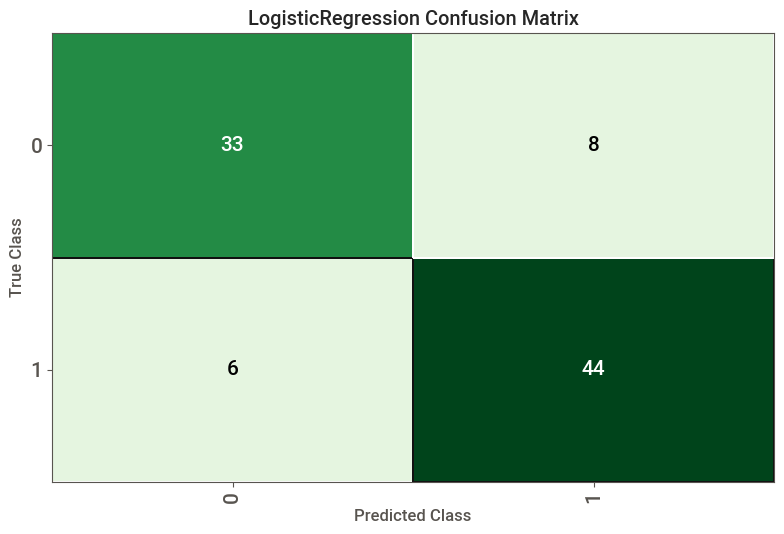

In [15]:
# create feature importance plot
plot_model(lr, plot='confusion_matrix')

In [16]:
!pip install optuna

  Using cached optuna-3.1.0-py3-none-any.whl (365 kB)
  Using cached cmaes-0.9.1-py3-none-any.whl (21 kB)


In [17]:
# Tune the hyper parameters of the lr model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC

tuned_lr_optuna,tuner_1 = tune_model(lr, 
                                   search_library = 'optuna',
                                   fold = 10,
                                   optimize = 'auc',
                                   choose_better = True, 
                                   return_tuner=True)

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,06:19:53
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Split,Fold,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


ValueError: Deprecated distribution is specified in `actual_estimator__C` of param_distributions. Rejecting this because it may cause unexpected behavior. Please use new distributions such as FloatDistribution etc.

In [ ]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuned_lr_optuna)